<h1>Bitcoin Price Predict</h1>

Sobre o Projeto: Esse projeto trata-se do desenvolvimento de um modelo preditivo para prever os preços futuros do Bitcoin em um 'range' de 30 dias, começando com a limpeza e pré-processamento de um dataset contendo os preços históricos do Bitcoin por minuto. Também foi desenvolvido uma funcionalidade utilizando regressão linear para prever os valores de alta, baixa e fechamento do bitcoin com base no valor de abertura da moeda. ("alterar caso o dataset mude")

In [5]:
import joblib
import nbformat
import math

import pandas as pd
import numpy as np
import seaborn as sns
import yfinance as yf
import plotly.express as px


from datetime import datetime
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from itertools import cycle

from matplotlib import pyplot as plt

<h2>Leitura e Tratamento dos dados</h2>

<h4>Obtendo os dados pelo yfinance</h4>

In [6]:
ticker = "BTC-USD"
btc_data = yf.Ticker(ticker).history(period="max")

btc_data = btc_data.reset_index()

btc_data["unix"] = btc_data["Date"].astype(int) // 10**9  
btc_data["date"] = btc_data["Date"].dt.strftime("%Y-%m-%d %H:%M:%S")  
btc_data["symbol"] = "BTC/USD" 
btc_data["Volume BTC"] = btc_data["Volume"] / btc_data["Close"]  
btc_data["Volume USD"] = btc_data["Volume"] 

btc_data = btc_data[["unix", "date", "symbol", "Open", "High", "Low", "Close", "Volume BTC", "Volume USD"]]
btc_data.columns = ["unix", "date", "symbol", "open", "high", "low", "close", "Volume BTC", "Volume USD"]

btc_data.to_csv("archive/yfinance_BTC.csv", index=False)

<h4>Lê os arquivos csv que contem os dados</h4>

Lendo arquivos baixados no kaggle(preços do BTC até 2021)

In [7]:
#df_BTC_daily = pd.read_csv("archive/BTC-Daily.csv")
#df_BTC_daily.head()

Colentando os dados com o yfinance(Dados sempre o mais atualizados)

In [8]:
df_BTC_daily = pd.read_csv("archive/yfinance_BTC.csv")
df_BTC_daily.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1410912000,2014-09-17 00:00:00,BTC/USD,465.864014,468.174011,452.421997,457.334015,46042.496981,21056800
1,1410998400,2014-09-18 00:00:00,BTC/USD,456.859985,456.859985,413.104004,424.440002,81243.991616,34483200
2,1411084800,2014-09-19 00:00:00,BTC/USD,424.102997,427.834991,384.532013,394.795990,96048.847915,37919700
3,1411171200,2014-09-20 00:00:00,BTC/USD,394.673004,423.295990,389.882996,408.903992,90152.213596,36863600
4,1411257600,2014-09-21 00:00:00,BTC/USD,408.084991,412.425995,393.181000,398.821014,66646.688715,26580100


<h2>Limpesa dos dados</h2>

<h4>Verifica a existência de dados nulos ou nan<h4>

In [9]:
df_BTC_daily.isnull().sum()

unix          0
date          0
symbol        0
open          0
high          0
low           0
close         0
Volume BTC    0
Volume USD    0
dtype: int64

<h4>Informa o tipo dos dados</h4>
O tipo 'object' indicam existência de strings entre os dados, oque se configura como sujeira(a depender do caso é claro, date e symbol tem que ser string mesmo)

In [10]:
df_BTC_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3723 entries, 0 to 3722
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   unix        3723 non-null   int64  
 1   date        3723 non-null   object 
 2   symbol      3723 non-null   object 
 3   open        3723 non-null   float64
 4   high        3723 non-null   float64
 5   low         3723 non-null   float64
 6   close       3723 non-null   float64
 7   Volume BTC  3723 non-null   float64
 8   Volume USD  3723 non-null   int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 261.9+ KB


<h2>Obs: Os dados estavam limpos, então não precisei limpar</h2>

<h4>Busca por valores nulos</h4>

In [11]:
print("Null values:", df_BTC_daily.isnull().values.sum())

Null values: 0


In [12]:
print("NaN values:", df_BTC_daily.isnull().values.any())

NaN values: False


<h2>Análise dos dados</h2>

<h4>Descreve estatisticamente os dados</h4>

In [13]:
cols = ['open', 'high', 'low', 'close', 'Volume BTC', 'Volume USD']
df_BTC_daily[cols].describe().T

,count,mean,std,min,25%,50%,75%,max
open,3723.0,1.880532e+04,2.081021e+04,1.768970e+02,1.191565e+03,9.277512e+03,3.014388e+04,9.900674e+04
high,3723.0,1.923154e+04,2.127633e+04,2.117310e+02,1.216540e+03,9.440650e+03,3.060324e+04,9.965550e+04
low,3723.0,1.836271e+04,2.033618e+04,1.715100e+02,1.177200e+03,9.132048e+03,2.957238e+04,9.723289e+04
close,3723.0,1.882964e+04,2.084407e+04,1.781030e+02,1.197140e+03,9.281510e+03,3.015856e+04,9.899766e+04
Volume BTC,3723.0,1.034734e+06,1.177007e+06,1.518324e+04,2.649839e+05,6.387791e+05,1.384152e+06,1.332866e+07
Volume USD,3723.0,1.812318e+10,1.970904e+10,5.914570e+06,3.519225e+08,1.441366e+10,2.919021e+10,3.509679e+11


<h4>Correlação dos dados</h4>

In [14]:
df_BTC_daily_copy = df_BTC_daily.copy()
df_BTC_daily_copy['date'] = pd.to_datetime(df_BTC_daily_copy['date'])
df_BTC_daily_copy = df_BTC_daily_copy.drop(columns=['symbol'])
df_BTC_daily_copy.corr()

,unix,date,open,high,low,close,Volume BTC,Volume USD
unix,1.000000,1.000000,0.817098,0.815489,0.819330,0.817038,0.224711,0.632539
date,1.000000,1.000000,0.817098,0.815489,0.819330,0.817038,0.224711,0.632539
open,0.817098,0.817098,1.000000,0.999549,0.999325,0.999028,-0.054646,0.653099
high,0.815489,0.815489,0.999549,1.000000,0.999182,0.999602,-0.052126,0.659357
low,0.819330,0.819330,0.999325,0.999182,1.000000,0.999484,-0.059145,0.643499
close,0.817038,0.817038,0.999028,0.999602,0.999484,1.000000,-0.055469,0.652756
Volume BTC,0.224711,0.224711,-0.054646,-0.052126,-0.059145,-0.055469,1.000000,0.522064
Volume USD,0.632539,0.632539,0.653099,0.659357,0.643499,0.652756,0.522064,1.000000


<h4>HeatMap da Correlação</h4>

['unix', 'date', 'open', 'high', 'low', 'close', 'Volume BTC', 'Volume USD']


<Axes: >

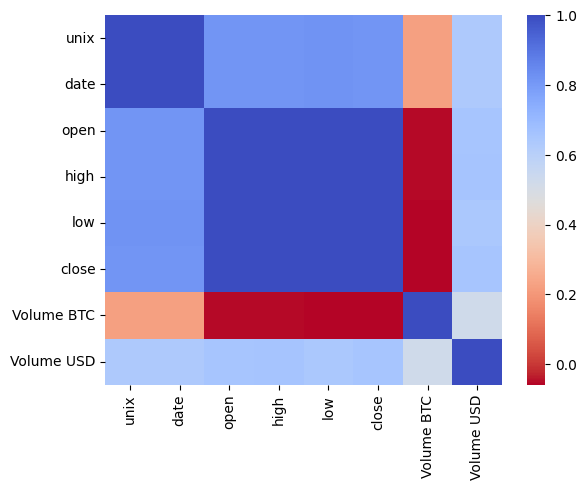

In [15]:
atributos = list(df_BTC_daily_copy.columns)
print(atributos)
sns.heatmap(df_BTC_daily_copy[atributos[:]].corr(), cmap='coolwarm_r')

<h2>Gráficos da correlação linear para o dataframe: 'df_BTC_daily'</h2>

<h4>Gráfico da reta entre 'open' e 'close'</h4>

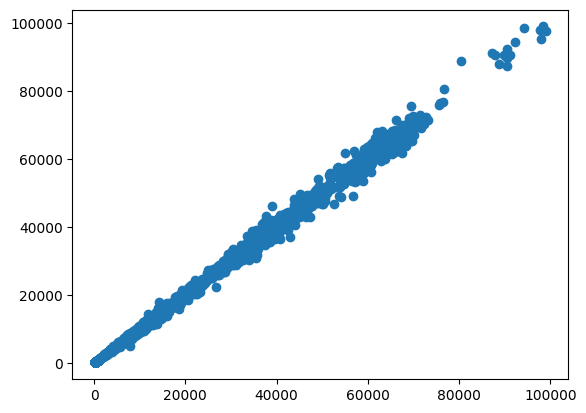

In [16]:

plt.scatter(df_BTC_daily["open"].values, df_BTC_daily["close"].values)

<h4>Gráfico da reta entre 'open' e 'high'</h4>

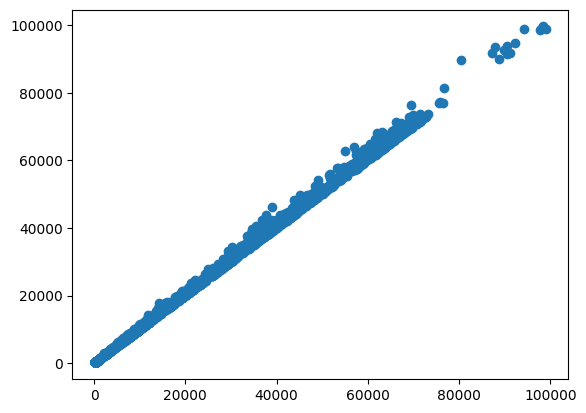

In [17]:
plt.scatter(df_BTC_daily["open"].values, df_BTC_daily["high"].values)

<h4>Gráfico da reta entre 'open' e 'low'</h4>

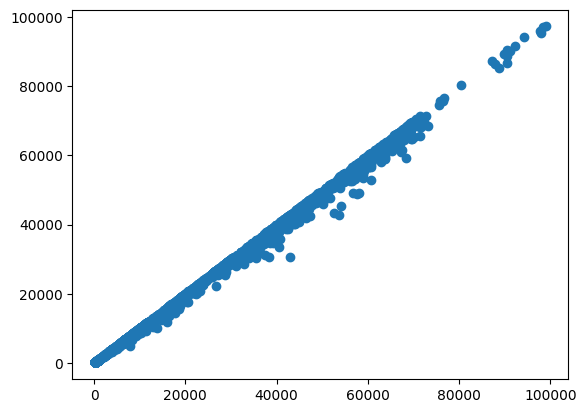

In [18]:
plt.scatter(df_BTC_daily["open"].values, df_BTC_daily["low"].values)

<h2>Criação dos modelos de Regressão Linear</h2>

Modelo de Regressao Linear(high)

In [19]:
x = df_BTC_daily["open"].values.reshape(-1, 1)
y = df_BTC_daily["high"].values

predict_teste_values = [[966.34], [912], [320]]

model_high = linear_model.LinearRegression()
model_high.fit(x, y)


LinearRegression()

In [20]:
joblib.dump(model_high, "models/high_model.pkl")
loaded_model = joblib.load("models/high_model.pkl") 

pred = loaded_model.predict(predict_teste_values)
print(pred)

[1001.21621556  945.68412459  340.69704593]


Modelo de Regressão Linear(Close)

In [21]:
x = df_BTC_daily["open"].values.reshape(-1, 1)
y = df_BTC_daily["close"].values

model_close = linear_model.LinearRegression()
model_close.fit(x, y)

LinearRegression()

In [22]:
joblib.dump(model_close, "models/close_model.pkl")
loaded_model = joblib.load("models/close_model.pkl") 

pred = loaded_model.predict(predict_teste_values)
print(pred)

[979.00594336 924.63045318 332.24381006]


Modelo de Regressão Linear(Low)

In [23]:
x = df_BTC_daily["open"].values.reshape(-1, 1)
y = df_BTC_daily["low"].values

model_low = linear_model.LinearRegression()
model_low.fit(x, y)

LinearRegression()

In [24]:
joblib.dump(model_low, "models/low_model.pkl")
loaded_model = joblib.load("models/low_model.pkl") 

pred = loaded_model.predict(predict_teste_values)
print(pred)

[941.84835374 888.78199233 310.65748083]


<h2>Previsão dos valores "high", "low" e "close" para hoje</h2>

In [25]:
bitcoin = yf.Ticker("BTC-USD")
historical_data = bitcoin.history(period="1d")

price_open = historical_data['Open'].iloc[0] if not historical_data.empty else None
price_open_ = [[price_open]]

high_model = joblib.load("models/high_model.pkl")
low_model = joblib.load("models/low_model.pkl") 
close_model = joblib.load("models/close_model.pkl")  

high_pred = high_model.predict(price_open_)
low_pred = low_model.predict(price_open_)
close_pred = close_model.predict(price_open_)

print(f"Preço de abertura do Bitcoin hoje: ${price_open}")
print(f"Preço mais alto previsto para o Bitcoin hoje: ${high_pred[0]}")
print(f"Preço mais baixo previsto para o Bitcoin hoje: ${low_pred[0]}")
print(f"Preço de fechamento do Bitcoin hoje: ${close_pred[0]}")


Preço de abertura do Bitcoin hoje: $97939.4765625
Preço mais alto previsto para o Bitcoin hoje: $100101.71384605269
Preço mais baixo previsto para o Bitcoin hoje: $95642.09700914494
Preço de fechamento do Bitcoin hoje: $98015.47695861963


<h1>Construindo o modelo LSMT</h1>

<h4>Preparando os dados para o treinamento</h4>

In [26]:
closed_date_df = df_BTC_daily[["date", "close"]]
print(f"shape of close_df: {closed_date_df.shape}")
closed_date_df.head()

shape of close_df: (3723, 2)


,date,close
0,2014-09-17 00:00:00,457.334015
1,2014-09-18 00:00:00,424.440002
2,2014-09-19 00:00:00,394.795990
3,2014-09-20 00:00:00,408.903992
4,2014-09-21 00:00:00,398.821014


In [27]:
grap = px.line(closed_date_df, x=closed_date_df.date, y=closed_date_df.close, labels={"date": "Date", "close": "Close Stack"})
grap.update_traces(marker_line_width=2, opacity=0.8, marker_line_color="orange")
grap.update_layout(title_text="Período considerado para prever o preço do Bitcoin", plot_bgcolor="white", font_size=15, font_color="black")
grap.update_xaxes(showgrid=False)
grap.update_yaxes(showgrid=False)
grap.show()

<h4>Como o preço do Bitcoin varia bastante ao longo dos anos, vamos utilizar dados de apenas um ano </h4>

In [28]:
closed_date_df = closed_date_df[closed_date_df["date"] > "2023-12-31"]
closed_stock = closed_date_df.copy()
print(f"Dados para a previsão: {closed_stock.shape[0]}") 
closed_stock.head()

Dados para a previsão: 331


,date,close
3392,2023-12-31 00:00:00,42265.187500
3393,2024-01-01 00:00:00,44167.332031
3394,2024-01-02 00:00:00,44957.968750
3395,2024-01-03 00:00:00,42848.175781
3396,2024-01-04 00:00:00,44179.921875


In [29]:
grap = px.line(closed_stock, x=closed_stock.date, y=closed_stock.close, labels={"date": "Date", "close": "Close Stack"})
grap.update_traces(marker_line_width=2, opacity=0.8, marker_line_color="orange")
grap.update_layout(title_text="Período considerado para prever o preço do Bitcoin", plot_bgcolor="white", font_size=15, font_color="black")
grap.update_xaxes(showgrid=False)
grap.update_yaxes(showgrid=False)
grap.show()

Normalizando a data

In [30]:
del closed_date_df["date"]
scaler = MinMaxScaler(feature_range=(0, 1))
closed_date_df= scaler.fit_transform(np.array(closed_date_df).reshape(-1, 1))
print(closed_date_df.shape)

(331, 1)


<h4>Separando os dados em dados de treino e dados de teste</h4>

In [31]:
training_size = int(len(closed_date_df)*0.60)
test_size = len(closed_date_df) - training_size
train_data, test_data = closed_date_df[0:training_size,:],closed_date_df[training_size:len(closed_date_df),:1]
print(f"train_data: {train_data.shape}")
print(f"train_data: {test_data.shape}")

train_data: (198, 1)
train_data: (133, 1)


<h4>Função para converter um array em uma matriz</h4>

In [32]:
def cerate_dataset(dataset, time_step=1):
    dataX = []
    dataY = []
    for i in range(len(dataset) - time_step -1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [33]:
time_stpe = 15
X_train, Y_train = cerate_dataset(train_data, time_stpe)
X_test, Y_test = cerate_dataset(test_data, time_stpe)

Modificando o formato dos dados para se adequarem ao formato exigido pelo LSTM

In [34]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

X_train: (182, 15, 1)
X_test: (117, 15, 1)


<h2>Construindo o Modelo</h2>

In [35]:
model = Sequential()
model.add(LSTM(10, input_shape=(None, 1), activation="relu"))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

In [36]:
result = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=200, batch_size=32, verbose=1)
joblib.dump(model, "models/LSTM_bitcoin_predict.pkl")
model = joblib.load("models/LSTM_bitcoin_predict.pkl")

Epoch 1/200
6/6 [==============================] - 1s 29ms/step - loss: 0.1833 - val_loss: 0.2638
Epoch 2/200
6/6 [==============================] - 0s 5ms/step - loss: 0.1461 - val_loss: 0.2133
Epoch 3/200
6/6 [==============================] - 0s 5ms/step - loss: 0.1135 - val_loss: 0.1690
Epoch 4/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0850 - val_loss: 0.1305
Epoch 5/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0614 - val_loss: 0.0981
Epoch 6/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0429 - val_loss: 0.0719
Epoch 7/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0292 - val_loss: 0.0503
Epoch 8/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0182 - val_loss: 0.0337
Epoch 9/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0109 - val_loss: 0.0213
Epoch 10/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0066 - val_loss: 0.0136
Epoch 11/200
6/6 [==========

<h4>Exibindo o "Loss" vs "Validation Loss"</h4>

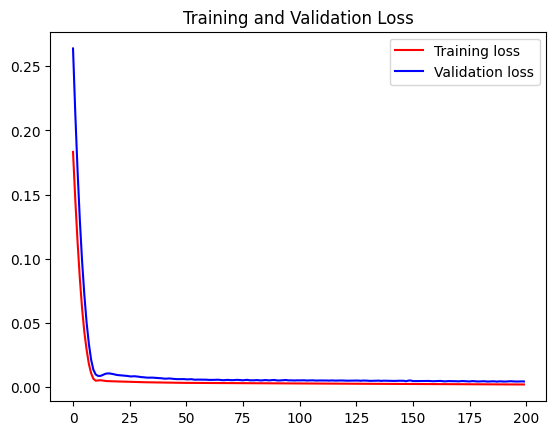

<Figure size 640x480 with 0 Axes>

In [37]:
loss = result.history["loss"]
val_loss = result.history["val_loss"]

epochs = range(len(loss))

plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and Validation Loss")
plt.legend(loc=0)
plt.figure()

plt.show()

<h4>Avaliação do Modelo</h4>

In [38]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict.shape, test_predict.shape

4/4 [==============================] - 0s 942us/step


((182, 1), (117, 1))

In [39]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(Y_train.reshape(-1, 1))
original_ytest = scaler.inverse_transform(Y_test.reshape(-1, 1))

<h4>Avaliação RMSE, MSE e MAE</h4>

In [40]:
print(f"Train data RMSE: {math.sqrt(mean_squared_error(original_ytrain, train_predict))}")
print(f"Train data MSE: {mean_squared_error(original_ytrain, train_predict)}")
print(f"Train date MAE: {mean_absolute_error(original_ytrain, train_predict)}")
print("=========================================================================================")
print(f"Test data RMSE: {math.sqrt(mean_squared_error(original_ytest, test_predict))}")
print(f"Test data MSE: {mean_squared_error(original_ytest, test_predict)}")
print(f"Test date MAE: {mean_absolute_error(original_ytest, test_predict)}")

Train data RMSE: 2770.584541462738
Train data MSE: 7676138.701392289
Train date MAE: 2204.9740942651097
Test data RMSE: 3998.5968432252903
Test data MSE: 15988776.714651257
Test date MAE: 2919.6352831196587


<h4>Pontuação da vairiancia da Regreção</h4>

In [41]:
print(f"Pontuação da variancia para os dados de treino: {explained_variance_score(original_ytrain, train_predict)}")
print(f"Pontuação da variancia para os dados de test: {explained_variance_score(original_ytest, test_predict)}")

Pontuação da variancia para os dados de treino: 0.9096935659137075
Pontuação da variancia para os dados de test: 0.8743164444887758


<h4>Raiz quadrada de regressão</h4>

In [42]:
print(f"Pontuação R2 treino: {r2_score(original_ytrain, train_predict)}")
print(f"Pontuação R2 test: {r2_score(original_ytest, test_predict)}")

Pontuação R2 treino: 0.9096755164886949
Pontuação R2 test: 0.8648997549468698


<h2>Prevendo os proximos 30 dias</h2>

In [43]:
#Entrada inicial para o modelo
x_input = test_data[len(test_data) - time_stpe:].reshape(1, -1)

#converte para lista para podermos adicinar novos valores a medida que o loop avança
temp_imput = list(x_input)
temp_imput = temp_imput[0].tolist()

#Aramazena os valores preveistos
lst_output = []
n_steps = time_stpe 
i = 0
pred_days = 30

while(i < pred_days):
    if(len(temp_imput) > time_stpe):
        x_input = np.array(temp_imput[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)

        temp_imput.extend(yhat[0].tolist())
        temp_imput = temp_imput[1:]
        
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_imput.extend(yhat[0].tolist())

        lst_output.extend(yhat.tolist())
        i=i+1

print(f"Output of predicted next days: {len(lst_output)}")
print(lst_output)

Output of predicted next days: 30
[[0.9268823266029358], [0.9243640303611755], [0.9225366711616516], [0.9204522967338562], [0.9188068509101868], [0.9166321158409119], [0.9143871665000916], [0.9122052788734436], [0.9098679423332214], [0.9072108864784241], [0.9042415618896484], [0.9006754755973816], [0.8969889283180237], [0.8934164643287659], [0.8897603750228882], [0.886422872543335], [0.8831484913825989], [0.8798611760139465], [0.8765519857406616], [0.8732218742370605], [0.869867742061615], [0.8664911985397339], [0.8630937933921814], [0.8596761226654053], [0.8562387824058533], [0.8527857065200806], [0.8493200540542603], [0.8458470702171326], [0.8423686027526855], [0.8388841152191162]]


<h2>Prevê o valor do Bitcoin para os proximos 30 dias</h2>

In [44]:
lstmdf = closed_date_df.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1, 1)).tolist())
#recupera os valores originais de preço,
lstmdf = scaler.inverse_transform(lstmdf).reshape(1, -1).tolist()[0]

historical_data = lstmdf[:-30]  
forecast_data = lstmdf[-30:]   

grap = px.line(labels={"value": "Stock", "index": "Timestamp"})
grap.add_scatter(x=list(range(len(historical_data))), y=historical_data, mode='lines', name='Dados Históricos', line=dict(color='blue'))
grap.add_scatter(x=list(range(len(historical_data), len(lstmdf))), y=forecast_data, mode='lines', name='Previsão (30 dias)', line=dict(color='orange'))
grap.update_layout(
    title_text="Gráfico com a previsão",
    plot_bgcolor="white",
    font_size=15,
    font_color="black",
    legend_title_text="Stock"
)
grap.update_xaxes(showgrid=False)
grap.update_yaxes(showgrid=False)
grap.show()